In [1]:
from torchvision import transforms

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchvision
import torch

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <44B645FB-F027-3EE5-86D7-DBF8E2FC6264> /Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('mps')

train_dataset = torchvision.datasets.MNIST('../data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = torchvision.datasets.MNIST('../data/', download=True, train=False, transform=transforms.ToTensor())
testloader   = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True)

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class Deflatten(nn.Module):
    def __init__(self, k):
        super(Deflatten, self).__init__()
        self.k = k

    def forward(self, x):
        s = x.size()
        feature_size = int((s[1] // self.k) ** 0.5)
        return x.view(s[0], self.k, feature_size, feature_size)

In [16]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        k = 16
        
        self.encoder = nn.Sequential(
                    nn.Conv2d(    1,     k, 3, stride=2),   nn.ReLU(),
                    nn.Conv2d(    k, 2 * k, 3, stride=2),   nn.ReLU(),
                    nn.Conv2d(2 * k, 4 * k, 3, stride=2),   nn.ReLU(),
                    nn.Conv2d(4 * k, 4 * k, 2, stride=2),   nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128, 50),            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(50, 128),                nn.ReLU(),
            Deflatten(8 * k),
            nn.ConvTranspose2d(4 * k, 4 * k, 2, stride=2),  nn.ReLU(),
            nn.ConvTranspose2d(4 * k, 2 * k, 2, stride=2),  nn.ReLU(),
            nn.ConvTranspose2d(2 * k,     k, 2, stride=2),  nn.ReLU(),
            nn.ConvTranspose2d(    k,     1, 1, stride=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [17]:
model = AutoEncoder().to(device)
critention = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
for epoch in range(51):
    running_loss = 0.0
    for data in trainloader:
        inputs = data[0].to(device)
        optimizer.zero_grad()

        _, outputs = model(inputs)
        loss = critention(inputs, outputs)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
    
    cost = running_loss / len(trainloader)
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs = data[0].to(device)
            optimizer.zero_grad()

            _, val_outputs = model(inputs)
            val_loss = critention(inputs, val_outputs)
    print("[%d] Train loss : %.6f\tTrain acc : %.6f\nValidation loss : %.6f\tValidation acc : %.6f" % (epoch + 1, cost, 1 - cost, val_loss, 1 - val_loss))

: 

: 

In [15]:
print(np.unique(prediction))

[ 2  7  9 12 13 18 19 21 22 27 30 31 34 36 38 39 41 42 45 47 48 49]


In [7]:
prediction, actual = [], []

with torch.no_grad():
    for image, labels in testloader:
        inputs = image.to(device)
        labels = labels.to(device)
        y_pred, _ = model(inputs)

        prediction += y_pred.cpu().tolist()
        actual += labels.cpu().tolist()

actual, prediction = np.array(actual), np.array(np.argmax(prediction, axis=1))
print(classification_report(actual, prediction))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.01      0.00      0.01      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          27       0.00      0.00      0.00         0
          30       0.00    

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bahk_ins

<AxesSubplot: >

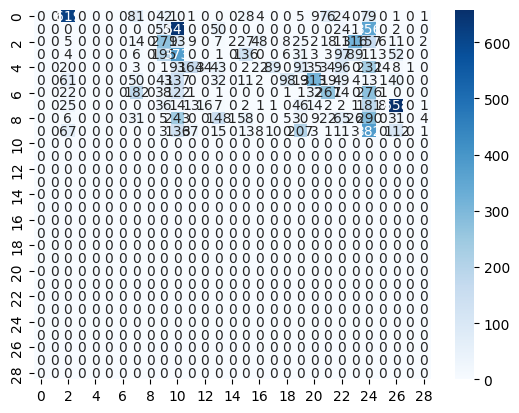

In [8]:
sns.heatmap(
    confusion_matrix(y_pred=prediction, y_true=actual), 
    annot=True, 
    cmap='Blues',
    fmt='',
)